In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


In [2]:
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)

def load_data():
    """
    Load the data and split it into train, validation, and test sets.
    """
    dataset_dir ='D:\Fingernails'
    images = []
    labels = []

    print("Loading dataset...")
    
    for folder in os.listdir(dataset_dir):
        label = class_names_label[folder]
        
        for file in tqdm(os.listdir(os.path.join(dataset_dir, folder))):
            
            img_path = os.path.join(os.path.join(dataset_dir, folder), file)
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE) 
            
            images.append(image)
            labels.append(label)
                
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    images, labels = shuffle(images, labels, random_state=25)
    
    # Splitting the data into 75% train, 10% validation, and 15% test
    split_1 = int(0.75 * len(images))
    split_2 = int(0.85 * len(images))
    
    train_images = images[:split_1]
    train_labels = labels[:split_1]
    
    val_images = images[split_1:split_2]
    val_labels = labels[split_1:split_2]
    
    test_images = images[split_2:]
    test_labels = labels[split_2:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

<>:10: SyntaxWarning: invalid escape sequence '\F'
<>:10: SyntaxWarning: invalid escape sequence '\F'
C:\Users\DELL\AppData\Local\Temp\ipykernel_1608\4282529622.py:10: SyntaxWarning: invalid escape sequence '\F'
  dataset_dir ='D:\Fingernails'


Loading dataset...


100%|██████████| 1695/1695 [00:06<00:00, 251.16it/s]


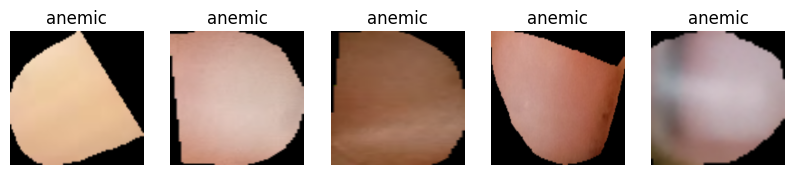

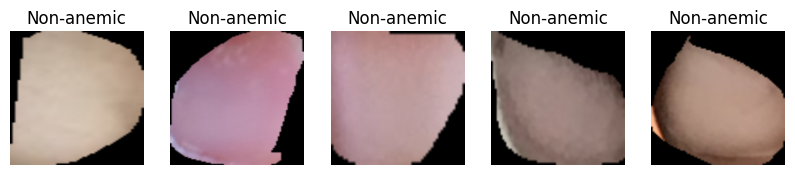

In [3]:
import matplotlib.pyplot as plt

def plot_class_images(images, labels, class_label, class_name, num_images=5):
    """
    Plots the first num_images images from the given class.
    """
    idxs = [i for i, label in enumerate(labels) if label == class_label][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot 5 images of class 'anemic' (label 0) and 5 images of class 'Non-anemic' (label 1)
plot_class_images(train_images, train_labels, class_label=0, class_name='anemic')
plot_class_images(train_images, train_labels, class_label=1, class_name='Non-anemic')


In [4]:
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 3195
Number of validation examples: 426
Number of testing examples: 639
Each image is of size: (224, 224)


In [5]:
# Compute class weights for the training data
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the first 250 layers
for layer in base_model.layers[:250]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the features globally
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add a dense layer with 1024 units
x = Dropout(0.5)(x)  # Apply dropout to prevent overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add another dense layer with 256 units
x = Dropout(0.4)(x)  # Apply more dropout
predictions = Dense(1, activation='sigmoid')(x)  # Final binary classification layer

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_2.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [8]:
# Train the model
batch_size = 32
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=100,  
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[early_stopping, checkpoint])



Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.6141 - loss: 14.0060 - val_accuracy: 0.6925 - val_loss: 11.1927
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.8102 - loss: 10.3824 - val_accuracy: 0.7958 - val_loss: 8.4994
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.9313 - loss: 7.8340 - val_accuracy: 0.9131 - val_loss: 6.5478
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9741 - loss: 6.0596 - val_accuracy: 0.9178 - val_loss: 5.3165
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9850 - loss: 4.8295 - val_accuracy: 0.9390 - val_loss: 4.2559
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.9887 - loss: 3.9068 - val_accuracy: 0.9319 - val_loss: 3.5490
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9839 - loss: 3.2167 - val_accuracy: 0.9437 - val_loss: 2.9012
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.9912 - loss: 2.6577

In [9]:
model.load_weights('best_model_2.keras')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2%}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9498 - loss: 0.1830
Test Accuracy: 94.99%


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predict probabilities
predictions = model.predict(test_images)

# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))


20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step
Classification Report:
              precision    recall  f1-score   support

      anemic       0.95      0.97      0.96       392
  Non-anemic       0.95      0.92      0.93       247

    accuracy                           0.95       639
   macro avg       0.95      0.94      0.95       639
weighted avg       0.95      0.95      0.95       639



In [11]:
precision = precision_score(test_labels, predicted_labels)
print(f'Precision: {precision}')

recall = recall_score(test_labels, predicted_labels)
print(f'Recall: {recall}')

f1 = f1_score(test_labels, predicted_labels)
print(f'F1 Score: {f1}')

Precision: 0.946058091286307
Recall: 0.9230769230769231
F1 Score: 0.9344262295081968


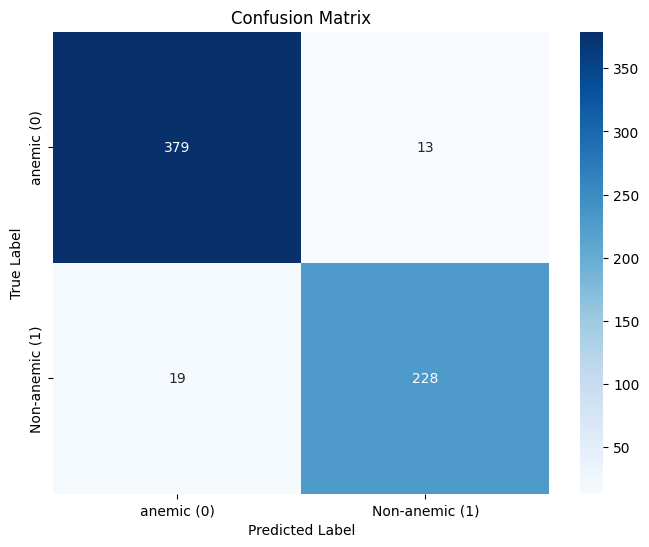

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Define class names with the correct labels
class_names = ['anemic (0)', 'Non-anemic (1)']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [13]:
model.save('FingerNails_densenet_3.h5')